In [1]:
!pip install geopandas rasterio openaq folium matplotlib seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 117.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 118.5 MB/s eta 0:00:00
  Attempting uninstall: httpcore
    Found existing installation: httpcore 1.0.2
    Uninstalling httpcore-1.0.2:
      Successfully uninstalled httpcore-1.0.2
  Attempting uninstall: httpx
    Found existing installation: httpx 0.27.0
    Uninstalling httpx-0.27.0:
      Successfully uninstalled httpx-0.27.0


In [4]:
!pip install geodatasets 

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Extracting 'nybb_16a/nybb.shp' from '/home/brintodibyendu/.cache/geodatasets/nybb_16a.zip' to '/home/brintodibyendu/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.shx' from '/home/brintodibyendu/.cache/geodatasets/nybb_16a.zip' to '/home/brintodibyendu/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.dbf' from '/home/brintodibyendu/.cache/geodatasets/nybb_16a.zip' to '/home/brintodibyendu/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.prj' from '/home/brintodibyendu/.cache/geodatasets/nybb_16a.zip' to '/home/brintodibyendu/.cache/geodatasets/nybb_16a.zip.unzip'
/tmp/ipykernel_223049/882355758.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  manhattan_geom = manhattan.geometry.unary_union


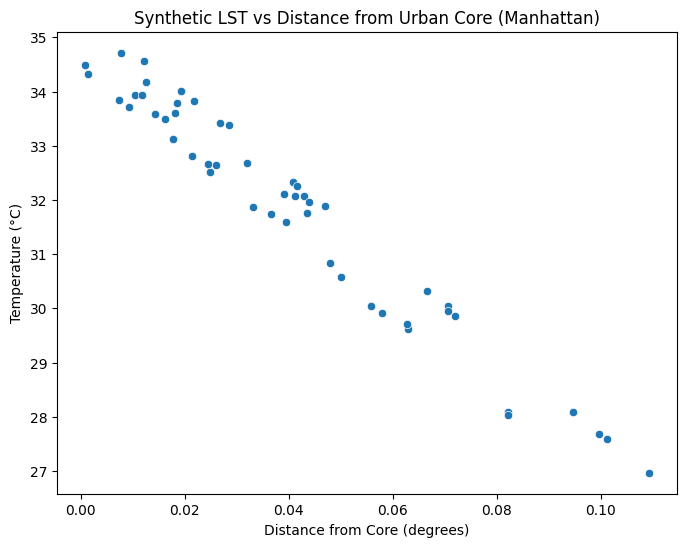

Interactive map saved as 'manhattan_uhi_map.html'.


In [5]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from rasterio.transform import from_bounds
import rasterio
from rasterio.io import MemoryFile
from geodatasets import get_path

# -------------------------------------
# 1. Load Manhattan Polygon from NYBB
# -------------------------------------
nybb_path = get_path('nybb')
nybb = gpd.read_file(nybb_path)
# Filter for Manhattan and ensure CRS is EPSG:4326
manhattan = nybb[nybb['BoroName'] == 'Manhattan'].to_crs(epsg=4326)
manhattan_geom = manhattan.geometry.unary_union

# -------------------------------------
# 2. Create a Synthetic LST Raster for Manhattan
# -------------------------------------
# Use Manhattan's bounding box as the raster extent
xmin, ymin, xmax, ymax = manhattan_geom.bounds
width, height = 100, 100  # raster dimensions (can be adjusted)

# Calculate Manhattan's centroid to serve as the urban core reference
centroid = manhattan_geom.centroid
centroid_x, centroid_y = centroid.x, centroid.y

# Create a grid of coordinates across the bounding box
x_coords = np.linspace(xmin, xmax, width)
y_coords = np.linspace(ymin, ymax, height)
xx, yy = np.meshgrid(x_coords, y_coords)

# Compute Euclidean distance from each cell center to the centroid
distances = np.sqrt((xx - centroid_x)**2 + (yy - centroid_y)**2)
# Normalize distances to range [0, 1]
max_distance = distances.max()
normalized_dist = distances / max_distance

# Define synthetic LST: highest at the urban core, decreasing toward the edge.
base_temp = 25      # base temperature in °C
intensity = 10      # additional temperature at the core
lst_array = base_temp + intensity * (1 - normalized_dist)

# Create an affine transform for the raster using the bounding box
transform = from_bounds(xmin, ymin, xmax, ymax, width, height)

# Create an in‑memory LST raster using Rasterio's MemoryFile
memfile = MemoryFile()
with memfile.open(driver='GTiff', height=height, width=width,
                  count=1, dtype='float32', crs="EPSG:4326", transform=transform) as lst_dataset:
    lst_dataset.write(lst_array.astype('float32'), 1)

    # -------------------------------------
    # 3. Sample LST Values at Random Points within Manhattan
    # -------------------------------------
    num_samples = 50  # number of sample points
    sample_points = []
    lst_values = []
    distances_from_center = []
    
    # Generate random points until we have the desired number within Manhattan
    while len(sample_points) < num_samples:
        rand_x = np.random.uniform(xmin, xmax)
        rand_y = np.random.uniform(ymin, ymax)
        pt = Point(rand_x, rand_y)
        if pt.within(manhattan_geom):
            # Sample the raster at the point's coordinates
            for val in lst_dataset.sample([(pt.x, pt.y)]):
                temperature = val[0]
            sample_points.append(pt)
            lst_values.append(temperature)
            # Compute distance from the centroid (urban core)
            dist_center = np.sqrt((pt.x - centroid_x)**2 + (pt.y - centroid_y)**2)
            distances_from_center.append(dist_center)

# Create a GeoDataFrame of the sampled points and their LST values
sample_df = pd.DataFrame({
    'temperature': lst_values,
    'distance': distances_from_center
})
sample_gdf = gpd.GeoDataFrame(sample_df, geometry=sample_points, crs="EPSG:4326")

# -------------------------------------
# 4. Visualize the Relationship
# -------------------------------------
# Scatter plot: Temperature vs. Distance from Urban Core
plt.figure(figsize=(8,6))
sns.scatterplot(data=sample_gdf, x='distance', y='temperature')
plt.title('Synthetic LST vs Distance from Urban Core (Manhattan)')
plt.xlabel('Distance from Core (degrees)')
plt.ylabel('Temperature (°C)')
plt.show()

# -------------------------------------
# 5. Create an Interactive Map with Folium
# -------------------------------------
# Center the map on Manhattan's centroid
center = [centroid.y, centroid.x]
m = folium.Map(location=center, zoom_start=12)

# Add circle markers for each sample point showing the temperature
for idx, row in sample_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        popup=f"Temp: {row['temperature']:.2f} °C",
        color='red',
        fill=True,
        fill_color='red'
    ).add_to(m)

# Save the interactive map to an HTML file
m.save("manhattan_uhi_map.html")
print("Interactive map saved as 'manhattan_uhi_map.html'.")


Processing Staten Island...


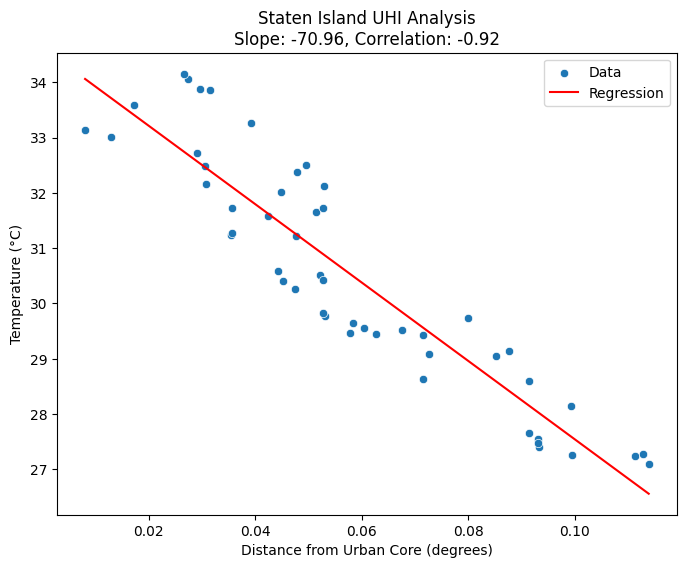

Processing Queens...


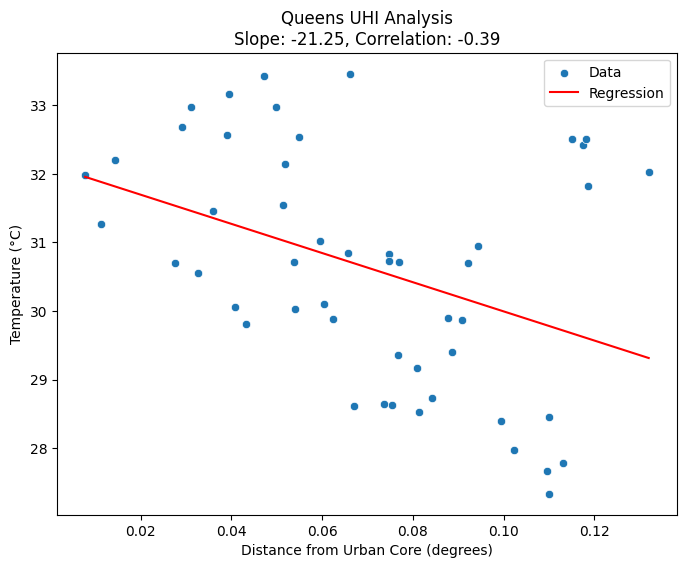

Processing Brooklyn...


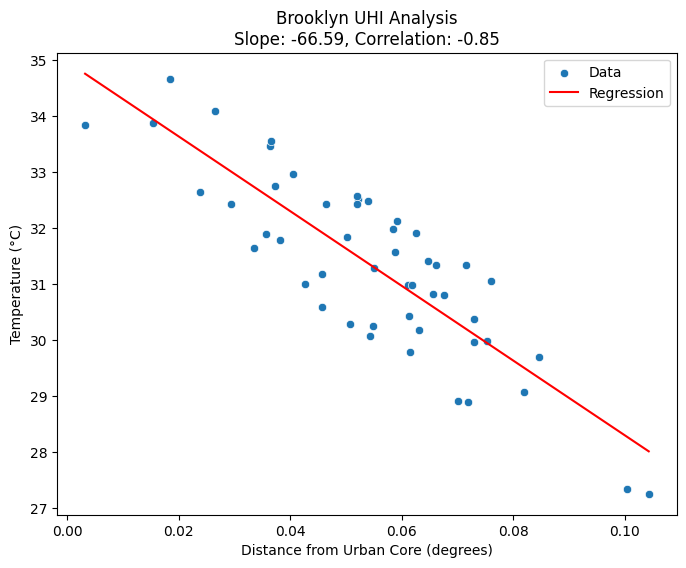

Processing Manhattan...


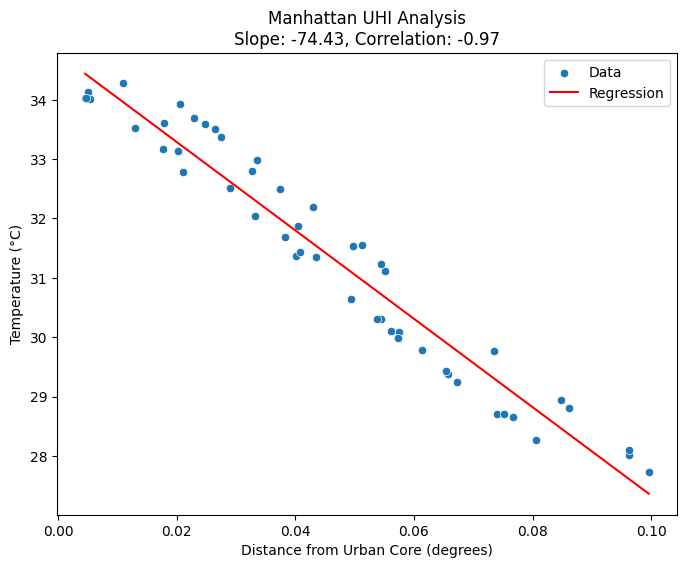

Processing Bronx...


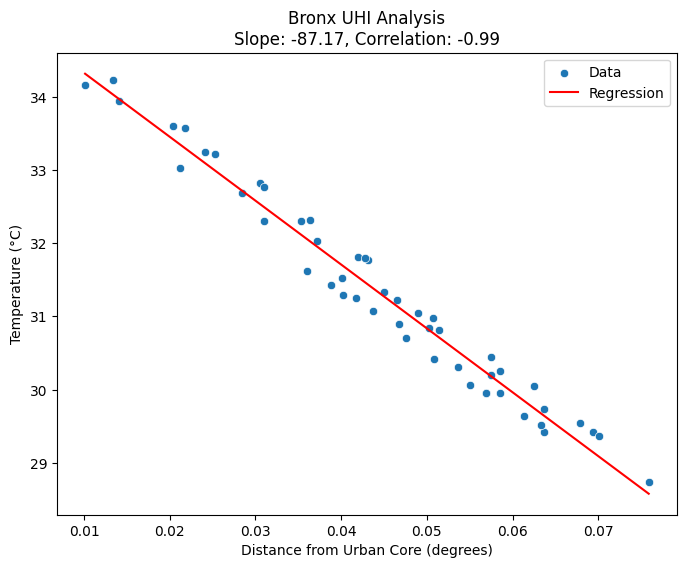

Interactive map saved as 'comparative_uhi_map.html'.


/tmp/ipykernel_223049/1406093629.py:124: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overall_centroid = [nybb.geometry.centroid.y.mean(), nybb.geometry.centroid.x.mean()]


In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.transform import from_bounds
import rasterio
from rasterio.io import MemoryFile
from geodatasets import get_path
import folium

# -------------------------------------
# 1. Load NYBB Dataset and Prepare Boroughs
# -------------------------------------
nybb_path = get_path('nybb')
nybb = gpd.read_file(nybb_path).to_crs(epsg=4326)

# Parameters for synthetic LST
base_temp = 25      # base temperature in °C
intensity = 10      # additional temperature at the core
width, height = 100, 100  # raster dimensions
num_samples = 50    # number of random sample points per borough

# Dictionary to store results for each borough
results = {}

# Loop over each borough (each row in the dataset)
for idx, row in nybb.iterrows():
    borough_name = row['BoroName']
    borough_geom = row.geometry
    print(f"Processing {borough_name}...")
    
    # -------------------------------------
    # 2. Create a Synthetic LST Raster for the Borough
    # -------------------------------------
    xmin, ymin, xmax, ymax = borough_geom.bounds
    centroid = borough_geom.centroid
    centroid_x, centroid_y = centroid.x, centroid.y
    
    # Create grid coordinates over the borough's bounding box
    x_coords = np.linspace(xmin, xmax, width)
    y_coords = np.linspace(ymin, ymax, height)
    xx, yy = np.meshgrid(x_coords, y_coords)
    
    # Compute Euclidean distance from each grid cell to the borough's centroid
    distances_grid = np.sqrt((xx - centroid_x)**2 + (yy - centroid_y)**2)
    max_distance = distances_grid.max()
    normalized_distance = distances_grid / max_distance
    
    # Synthetic LST: higher temperature at the core, decreasing outward.
    lst_array = base_temp + intensity * (1 - normalized_distance)
    transform = from_bounds(xmin, ymin, xmax, ymax, width, height)
    
    # Create an in-memory raster with Rasterio
    memfile = MemoryFile()
    with memfile.open(driver='GTiff', height=height, width=width,
                      count=1, dtype='float32', crs="EPSG:4326", transform=transform) as lst_dataset:
        lst_dataset.write(lst_array.astype('float32'), 1)
        
        # -------------------------------------
        # 3. Sample LST Values at Random Points within the Borough
        # -------------------------------------
        sample_points = []
        lst_values = []
        distances_from_center = []
        attempts = 0
        # Loop until we have the desired number of samples (or a max attempts threshold)
        while len(sample_points) < num_samples and attempts < num_samples * 10:
            rand_x = np.random.uniform(xmin, xmax)
            rand_y = np.random.uniform(ymin, ymax)
            pt = Point(rand_x, rand_y)
            if pt.within(borough_geom):
                # Sample the LST value from the raster at this point
                for val in lst_dataset.sample([(pt.x, pt.y)]):
                    temperature = val[0]
                sample_points.append(pt)
                lst_values.append(temperature)
                # Compute distance from the centroid (urban core)
                dist_center = np.sqrt((pt.x - centroid_x)**2 + (pt.y - centroid_y)**2)
                distances_from_center.append(dist_center)
            attempts += 1

    # Create a DataFrame for the samples
    df = pd.DataFrame({
        'temperature': lst_values,
        'distance': distances_from_center
    })
    
    # -------------------------------------
    # 4. Linear Regression Analysis: Temperature vs. Distance
    # -------------------------------------
    if len(df) > 0:
        slope, intercept = np.polyfit(df['distance'], df['temperature'], 1)
        df['predicted'] = intercept + slope * df['distance']
        correlation = df['temperature'].corr(df['distance'])
    else:
        slope, intercept, correlation = None, None, None

    # Store results
    results[borough_name] = {
        'data': df,
        'slope': slope,
        'intercept': intercept,
        'correlation': correlation,
        'centroid': (centroid.y, centroid.x)
    }
    
    # -------------------------------------
    # 5. Plot the Relationship for the Borough
    # -------------------------------------
    plt.figure(figsize=(8,6))
    sns.scatterplot(x='distance', y='temperature', data=df, label='Data')
    sns.lineplot(x='distance', y='predicted', data=df, color='red', label='Regression')
    plt.title(f'{borough_name} UHI Analysis\nSlope: {slope:.2f}, Correlation: {correlation:.2f}')
    plt.xlabel('Distance from Urban Core (degrees)')
    plt.ylabel('Temperature (°C)')
    plt.show()

# -------------------------------------
# 6. Create an Interactive Comparative Map with Folium
# -------------------------------------
# Center the map on the overall centroid of all boroughs
overall_centroid = [nybb.geometry.centroid.y.mean(), nybb.geometry.centroid.x.mean()]
m = folium.Map(location=overall_centroid, zoom_start=10)

for borough_name, info in results.items():
    centroid_coords = info['centroid']
    popup_text = (f"{borough_name}<br>"
                  f"Slope: {info['slope']:.2f}<br>"
                  f"Correlation: {info['correlation']:.2f}")
    folium.Marker(location=centroid_coords, popup=popup_text).add_to(m)

m.save("comparative_uhi_map.html")
print("Interactive map saved as 'comparative_uhi_map.html'.")
